# Imports

In [129]:
import plotly.graph_objs as go
import plotly.offline as pyo
import plotly.io as pio
import ta
import pandas as pd
import numpy as np
import yfinance as yf
from pandas import DataFrame, Series
# Set the default template to plotly_dark
pio.templates.default = 'plotly_dark'
import warnings
warnings.filterwarnings("ignore")

# Collect Data

In [28]:
import yfinance as yf
import pandas as pd


class StockData:
    """
    A class that retrieves historical stock data from Yahoo Finance using the yfinance library.

    Attributes:
        symbol (str): The stock symbol to retrieve data for.

        start_date (str): The start date of the date range to retrieve data for, in YYYY-MM-DD format.

        end_date (str): The end date of the date range to retrieve data for, in YYYY-MM-DD format.

        interval (str): The time interval between data points. Valid values are '1d' (daily), '1wk' (weekly), '1mo' (monthly), '1m' (1-minute), '2m' (2-minute), '5m' (5-minute), '15m' (15-minute), '30m' (30-minute), '60m' (60-minute), '90m' (90-minute), and '1h' (hourly).

        data (pandas.DataFrame): The retrieved stock data.
    """

    def __init__(self, symbol, start_date=None, end_date=None, interval="1d") -> None:

        self.startup(symbol, start_date, end_date, interval)

    def startup(self, symbol, start_date, end_date, interval) -> None:
        """
        Constructs a new StockData object and downloads the stock data from Yahoo Finance.

        Args:
            symbol (str): The stock symbol to retrieve data for.

            start_date (str): The start date of the date range to retrieve data for, in YYYY-MM-DD format.

            end_date (str): The end date of the date range to retrieve data for, in YYYY-MM-DD format.

            interval (str, optional): The time interval between data points. Default is '1d' for daily data. Valid values are '1d' (daily), '1wk' (weekly), '1mo' (monthly), '1m' (1-minute), '2m' (2-minute), '5m' (5-minute), '15m' (15-minute), '30m' (30-minute), '60m' (60-minute), '90m' (90-minute), and '1h' (hourly).
        """
        self.symbol: str = symbol
        self.start_date: str = start_date
        self.end_date: str = end_date
        self.interval: str = interval
        self.data: DataFrame = yf.download(
            symbol, start=start_date, end=end_date, interval=interval
        )

    def __repr__(self) -> str:
        """
        Returns a string representation of the StockData object.
        """
        return f"StockData(symbol={self.symbol}, start_date={self.start_date}, end_date={self.end_date}, interval={self.interval})"

    def __str__(self) -> str:
        """
        Returns a string representation of the stock data.
        """
        return str(self.data)

In [29]:
stockdata = StockData(
    symbol='TSLA'
)

[*********************100%***********************]  1 of 1 completed


In [30]:
stockdata

StockData(symbol=TSLA, start_date=None, end_date=None, interval=1d)

In [32]:
stockdata.data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500


# Calculate Technical Indicators

For our analysis we will use the following the most prominent and all-time popular indicators: 


#### Moving averages:

- Help to smooth out price fluctuations and identify trends in the data over time.
Provide an indication of the average price of a security over a specific period.
Can be used to identify support and resistance levels, and to signal potential trend reversals.

#### Relative Strength Index (RSI):

- Measures the strength of a security's recent price movements.
Ranges from 0 to 100, with values above 70 indicating an overbought condition and values below 30 indicating an oversold condition.
Can be used to identify potential trend reversals and to confirm the strength of an existing trend.

#### Moving Average Convergence Divergence (MACD):

- Uses moving averages to identify changes in momentum and trend.
Consists of two lines - the MACD line and the signal line - that cross over each other to generate buy and sell signals.
Can be used to identify potential trend reversals and to confirm the strength of an existing trend.

#### Average Directional Index (ADX):

- Measures the strength of a trend, whether it's up or down.
Ranges from 0 to 100, with values above 25 indicating a strong trend.
Can be used to identify potential trend reversals and to determine whether a security is in a trading range or trending.

#### On-Balance Volume (OBV):

- Measures buying and selling pressure by tracking the volume of trades on up and down days.
When the OBV is rising, it indicates that buying pressure is increasing, and when it's falling, it indicates that selling pressure is increasing.

- Can be used to confirm the strength of a trend and to identify potential trend reversals.
These technical indicators are valuable tools for traders and investors looking to analyze financial market data and make informed decisions about their investments. By understanding the signals generated by these indicators, investors can gain insights into the direction and momentum of a security's price movements and adjust their investment strategies accordingly.

In [121]:
class TechnicalIndicators:
    """
    A class that calculates various technical indicators for a given stock price dataset.
    """

    def __init__(
        self, data, sma_window=20, ema_window=20, rsi_window=14, adx_window=14, bb_window=20, bb_std=2
    ) -> None:
        """
        Constructs a new TechnicalIndicators object.

        Args:
            data (pandas.DataFrame): The stock price dataset to calculate technical indicators for.
            sma_window (int, optional): The window size for the simple moving average. Default is 20.
            ema_window (int, optional): The window size for the exponential moving average. Default is 20.
            rsi_window (int, optional): The window size for the Relative Strength Index. Default is 14.
            adx_window (int, optional): The window size for the Average Directional Index. Default is 14.
            bb_window (int, optional): The window size for the Bollinger Bands. Default is 20.
            bb_std (float, optional): The number of standard deviations to use for the Bollinger Bands. Default is 2.
        """
        self.data = data.data
        self.symbol = data.symbol
        self.sma_window = sma_window
        self.ema_window = ema_window
        self.rsi_window = rsi_window
        self.adx_window = adx_window
        self.bb_window = bb_window
        self.bb_std = bb_std

    def calculate_sma(self) -> Series:
        """
        Calculates the simple moving average and adds it to the dataset.

        Returns:
            pandas.Series: The simple moving average.
        """
        sma: Series = ta.trend.sma_indicator(self.data["Close"], window=self.sma_window)
        self.data["SMA"] = sma
        return sma

    def calculate_ema(self) -> Series:
        """
        Calculates the exponential moving average and adds it to the dataset.

        Returns:
            pandas.Series: The exponential moving average.
        """
        ema: Series = ta.trend.ema_indicator(self.data["Close"], window=self.ema_window)
        self.data["EMA"] = ema
        return ema

    def calculate_macd(self) -> Series:
        """
        Calculates the Moving Average Convergence Divergence (MACD) and adds it to the dataset.

        Returns:
            pandas.DataFrame: A dataframe with the MACD, signal line, and histogram.
        """
        macd, signal, hist = (
            ta.trend.macd(self.data["Close"]),
            ta.trend.macd_signal(self.data["Close"]),
            ta.trend.macd_diff(self.data["Close"]),
        )
        self.data["MACD"] = macd
        self.data["Signal"] = signal
        self.data["Histogram"] = hist
        return self.data[["MACD", "Signal", "Histogram"]]

    def calculate_rsi(self) -> Series:
        """
        Calculates the Relative Strength Index (RSI) and adds it to the dataset.

        Returns:
            pandas.Series: The RSI.
        """
        rsi: Series = ta.momentum.rsi(self.data["Close"], window=self.rsi_window)
        self.data["RSI"] = rsi
        return rsi
    
    def calculate_adx(self) -> Series:
            """
            Calculates the Average Directional Index (ADX) and adds it to the dataset.

            Returns:
                pandas.Series: The ADX.
            """
            adx: Series = ta.trend.adx(
                self.data["High"],
                self.data["Low"],
                self.data["Close"],
                window=self.adx_window,
                fillna=True,
            )
            self.data["ADX"] = adx
            return adx    


    def calculate_obv(self) -> Series:
        """
        Calculates the On-Balance Volume (OBV) and adds it to the dataset.

        Returns:
            pandas.Series: The OBV.
        """
        obv: Series = ta.volume.on_balance_volume(self.data["Close"], self.data["Volume"])
        self.data["OBV"] = obv
        return obv

    def calculate_bollinger_bands(self, window=20, k=2) -> DataFrame:
        """
        Calculates the Bollinger Bands and adds them to the dataset.

        Args:
            window (int, optional): The window size for the moving average. Default is 20.
            k (float, optional): The number of standard deviations to use for the upper and lower bands.
                Default is 2.

        Returns:
            pandas.DataFrame: The complete dataset with the Bollinger Bands appended to it.
        """
        ma: Series = ta.trend.sma_indicator(self.data["Close"], window=window)
        std: Series = ta.volatility.bollinger_mavg(self.data["Close"], window=window, fillna=True)
        upper_band: Series = ma + k * std
        lower_band: Series = ma - k * std
        band_width: Series = (upper_band - self.data["Close"]) / self.data["Close"]

        self.data["Upper Band"] = upper_band
        self.data["Lower Band"] = lower_band
        self.data["Band Width"] = band_width

        return self.data


    def calculate_all(
        self, sma_window=None, ema_window=None, rsi_window=None, adx_window=None, bb_window=None, bb_std=None
    ) -> DataFrame:
        """
        Calculates all technical indicators and adds them to the dataset.

        Args:
            sma_window (int, optional): The window size for the simple moving average. Default is the value specified in the constructor.
            ema_window (int, optional): The window size for the exponential moving average. Default is the value specified in the constructor.
            rsi_window (int, optional): The window size for the Relative Strength Index. Default is the value specified in the constructor.
            adx_window (int, optional): The window size for the Average Directional Index. Default is the value specified in the constructor.
            bb_window (int, optional): The window size for the Bollinger Bands. Default is the value specified in the constructor.
            bb_std (float, optional): The number of standard deviations to use for the Bollinger Bands. Default is the value specified in the constructor.

        Returns:
            pandas.DataFrame: The complete dataset with the technical indicators appended to it.
        """
        if sma_window is not None:
            self.sma_window = sma_window
        if ema_window is not None:
            self.ema_window = ema_window
        if rsi_window is not None:
            self.rsi_window = rsi_window
        if adx_window is not None:
            self.adx_window = adx_window
        if bb_window is not None:
            self.bb_window = bb_window
        if bb_std is not None:
            self.bb_std = bb_std

        data_copy = self.data.copy()

        self.calculate_sma()
        self.calculate_ema()
        self.calculate_macd()
        self.calculate_rsi()
        self.calculate_adx()
        self.calculate_obv()
        self.calculate_bollinger_bands()

        return self.data

In [134]:
technicalIndicators = TechnicalIndicators(stockdata)
df: DataFrame = technicalIndicators.calculate_all()

Overview of the dataframe including all the technical indicators

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3217 entries, 2010-06-29 to 2023-04-10
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        3217 non-null   float64
 1   High        3217 non-null   float64
 2   Low         3217 non-null   float64
 3   Close       3217 non-null   float64
 4   Adj Close   3217 non-null   float64
 5   Volume      3217 non-null   int64  
 6   SMA         3198 non-null   float64
 7   EMA         3198 non-null   float64
 8   MACD        3192 non-null   float64
 9   Signal      3184 non-null   float64
 10  Histogram   3184 non-null   float64
 11  RSI         3204 non-null   float64
 12  ADX         3217 non-null   float64
 13  OBV         3217 non-null   int64  
 14  Upper Band  3198 non-null   float64
 15  Lower Band  3198 non-null   float64
 16  Band Width  3198 non-null   float64
dtypes: float64(15), int64(2)
memory usage: 452.4 KB


In [137]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'SMA', 'EMA',
       'MACD', 'Signal', 'Histogram', 'RSI', 'ADX', 'OBV', 'Upper Band',
       'Lower Band', 'Band Width'],
      dtype='object')

In [138]:
df.iloc[40:45]

,Open,High,Low,Close,Adj Close,Volume,SMA,EMA,MACD,Signal,Histogram,RSI,ADX,OBV,Upper Band,Lower Band,Band Width
Date,,,,,,,,,,,,,,,,,
2010-08-25,1.277333,1.332000,1.237333,1.326667,1.326667,7549500,1.302433,1.300572,-0.022248,-0.031415,0.009168,51.202989,6.780158,-175060500,3.9073,-1.302433,1.945200
2010-08-26,1.326000,1.351333,1.306667,1.316667,1.316667,6507000,1.300433,1.302105,-0.018465,-0.028825,0.010361,50.232016,6.928060,-181567500,3.9013,-1.300433,1.963012
2010-08-27,1.316667,1.324667,1.300000,1.313333,1.313333,5694000,1.299633,1.303174,-0.015556,-0.026171,0.010615,49.892323,6.962826,-187261500,3.8989,-1.299633,1.968706
2010-08-30,1.313333,1.346000,1.307333,1.324667,1.324667,10992000,1.296133,1.305221,-0.012196,-0.023376,0.011180,51.102918,7.282673,-176269500,3.8884,-1.296133,1.935379
2010-08-31,1.310667,1.319333,1.288667,1.298667,1.298667,3016500,1.287900,1.304597,-0.011498,-0.021001,0.009502,48.224588,7.266358,-179286000,3.8637,-1.287900,1.975128


# Dashboard

In [228]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots


class Dashboard:
    """
    A class that generates a financial dashboard using Plotly.
    """

    def __init__(self, technicalIndicators: TechnicalIndicators) -> None:
        """
        Constructs a new PlotlyDashboard object.

        Args:
            technicalIndicators (TechnicalIndicators): The stock price dataset with all technical indicators calculated.
        """
        self.data: DataFrame = technicalIndicators.calculate_all()
        self.symbol: str = technicalIndicators.symbol
        

    def generate_candlestick(self) -> go.Candlestick:
        """
        Generates a candlestick chart.

        Returns:
            plotly.graph_objs.Candlestick: The candlestick chart.
        """
        return go.Candlestick(
            x=self.data.index,
            open=self.data["Open"],
            high=self.data["High"],
            low=self.data["Low"],
            close=self.data["Close"],
            name="Candlestick",
            increasing=dict(line=dict(color="#00FF00")),
            decreasing=dict(line=dict(color="#FF0000")),
            legendgroup="MA",
            legendgrouptitle_text="MA",
        )

    def generate_sma(self) -> go.Scatter:
        """
        Generates a simple moving average line chart.

        Returns:
            plotly.graph_objs.Scatter: The simple moving average chart.
        """
        return go.Scatter(
            x=self.data.index,
            y=self.data["SMA"],
            mode="lines",
            name=f"SMA ({self.data['SMA'].name})",
            legendgroup="MA",
            legendgrouptitle_text="MA",
        )

    def generate_ema(self) -> go.Scatter:
        """
        Generates an exponential moving average line chart.

        Returns:
            plotly.graph_objs.Scatter: The exponential moving average chart.
        """
        return go.Scatter(
            x=self.data.index,
            y=self.data["EMA"],
            mode="lines",
            name=f"EMA ({self.data['EMA'].name})",
            legendgroup="MA",
            legendgrouptitle_text="MA",
        )

    def generate_macd(self) -> go.Scatter:
        """
        Generates a MACD chart.

        Returns:
            plotly.graph_objs.Scatter: The MACD chart.
        """
        return go.Scatter(
            x=self.data.index,
            y=self.data["MACD"],
            mode="lines",
            name="MACD",
            legendgroup="MACD",
            legendgrouptitle_text="MACD",
        )

    def generate_macd_signal(self) -> go.Scatter:
        """
        Generates a MACD signal line chart.

        Returns:
            plotly.graph_objs.Scatter: The MACD signal line chart.
        """
        return go.Scatter(
            x=self.data.index,
            y=self.data["Signal"],
            mode="lines",
            name="Signal",
            legendgroup="MACD",
            legendgrouptitle_text="MACD",
        )

    def generate_macd_histogram(self) -> go.Bar:
        """
        Generates a MACD histogram bar chart.

        Returns:
            plotly.graph_objs.Bar: The MACD histogram chart.
        """
        return go.Bar(
            x=self.data.index,
            y=self.data["Histogram"],
            name="Histogram",
            legendgroup="MACD",
            legendgrouptitle_text="MACD",
        )

    def generate_rsi(self) -> tuple[go.Scatter, go.Scatter, go.Scatter]:
        """
        Generates a Relative Strength Index (RSI) line chart.

        Returns:
            plotly.graph_objs.Scatter: The RSI chart.
        """
        rsi_chart = go.Scatter(
            x=self.data.index,
            y=self.data["RSI"],
            mode="lines",
            name=f"RSI ({self.data['RSI'].name})",
            line=dict(color="blue"),
            legendgroup="Momentum",
            legendgrouptitle_text="Momentum",
        )
        rsi_30_line = go.Scatter(
            x=self.data.index,
            y=[30] * len(self.data.index),
            mode="lines",
            name="RSI 30",
            line=dict(color="red", dash="dash"),
            legendgroup="Momentum",
            legendgrouptitle_text="Momentum",
        )
        rsi_70_line = go.Scatter(
            x=self.data.index,
            y=[70] * len(self.data.index),
            mode="lines",
            name="RSI 70",
            line=dict(color="green", dash="dash"),
            legendgroup="Momentum",
            legendgrouptitle_text="Momentum",
        )
        return rsi_chart, rsi_30_line, rsi_70_line

    def generate_adx(self) -> go.Scatter:
        """
        Generates an Average Directional Index (ADX) line chart.

        Returns:
            plotly.graph_objs.Scatter: The ADX chart.
        """
        return go.Scatter(
            x=self.data.index,
            y=self.data["ADX"],
            mode="lines",
            name=f"ADX ({self.data['ADX'].name})",
            legendgroup="Momentum",
            legendgrouptitle_text="Momentum",
        )

    def generate_obv(self) -> go.Scatter:
        """
        Generates an On Balance Volume (OBV) line chart.

        Returns:
            plotly.graph_objs.Scatter: The OBV chart.
        """
        return go.Scatter(
            x=self.data.index,
            y=self.data["OBV"],
            mode="lines",
            name=f"OBV ({self.data['OBV'].name})",
            legendgroup="Volume",
            legendgrouptitle_text="Volume",
        )

    # previous methods omitted for brevity

    def generate_bollinger_bands(self) -> tuple[go.Scatter, go.Scatter, go.Scatter]:
        """
        Generates a Bollinger Bands plot.

        Returns:
            plotly.graph_objs.Scatter: The Bollinger Bands plot.
        """
        return (
            go.Scatter(
                x=self.data.index,
                y=self.data["Upper Band"],
                mode="lines",
                name="Bollinger Bands (Upper)",
                legendgroup="Bollinger Bands",
                legendgrouptitle_text="BBANDS",
            ),
            go.Scatter(
                x=self.data.index,
                y=self.data["Band Width"],
                mode="lines",
                name="Bollinger Bands (Mid)",
                legendgroup="Bollinger Bands",
                legendgrouptitle_text="BBANDS",
            ),
            go.Scatter(
                x=self.data.index,
                y=self.data["Lower Band"],
                mode="lines",
                name="Bollinger Bands (Lower)",
                legendgroup="Bollinger Bands",
                legendgrouptitle_text="BBANDS",
            ),
        )

    def describe_indicators(self) -> tuple[go.Indicator, go.Indicator, go.Indicator, go.Indicator, go.Indicator]:
        # Add stock statistics indicators to the first subplot
        max_close: float = self.data["Close"].max()
        min_close: float = self.data["Close"].min()
        mean_close: float = self.data["Close"].mean()
        std_close: float = self.data["Close"].std()
        title_size = 12
        value_size = 20
        return (
            go.Indicator(
            mode="number+delta",
            value=self.data["Close"].iloc[-1],
            delta={
                "reference": self.data["Close"].iloc[-2],
                "valueformat": ".2%",
            },
            title={"text": "Current Close Price", "font": {"size": title_size}},
            # domain={"x": [0.0, 0.25], "y": [0.8, 1.0]},
                number={"font": {"size": value_size}
    }
            ),
            go.Indicator(
                mode="number",
                value=max_close,
                title={"text": "Max Close Price", "font": {"size": title_size}},
                # domain={"x": [0.25, 0.5], "y": [0.8, 1.0]},
                    number={"font": {"size": value_size}
    }
            ),
            go.Indicator(
                mode="number",
                value=min_close,
                title={"text": "Min Close Price", "font": {"size": title_size}},
                domain={"x": [0.5, 0.75], "y": [0.8, 1.0]},
                    number={"font": {"size": value_size}
    }
            ),
            go.Indicator(
                mode="number",
                value=mean_close,
                title={"text": "Mean Close Price", "font": {"size": title_size}},
                # domain={"x": [0.75, 1.0], "y": [0.8, 1.0]},
                    number={"font": {"size": value_size}
    }
            ),
            go.Indicator(
                mode="number",
                value=std_close,
                title={"text": "Std Close Price", "font": {"size": title_size}},
                # domain={"x": [0.0, 0.25], "y": [0.6, 0.8]},
                    number={"font": {"size": value_size}
    }
            ),
        )


    # Define other methods to generate figures

    def plot(self) -> go.Figure:
        """
        Combines all the figures into a single subplot.

        Returns:
            plotly.graph_objs.Figure: The combined subplot figure.
        """
        # Add stock statistics indicators to the first subplot
        indicator1, indicator2, indicator3, indicator4, indicator5 = self.describe_indicators()

        fig = make_subplots(
            rows=5, cols=5, shared_xaxes=True, vertical_spacing=0.05,
            row_heights=[0.1, 0.20, 0.20, 0.20, 0.20],
            specs = [
                [{"type": "Indicator"}, {"type": "Indicator"}, {"type": "Indicator"}, {"type": "Indicator"}, {"type": "Indicator"}],
                [{'colspan':5}, {}, {}, {}, {}],
                [{'colspan':5}, {}, {}, {}, {}],
                [{'colspan':5}, {}, {}, {}, {}],
                [{'colspan':5}, {}, {}, {}, {}],
            ]
        )

        # Add the indicators to the first row
        fig.add_trace(indicator1, row=1, col=1)
        fig.add_trace(indicator2, row=1, col=2)
        fig.add_trace(indicator3, row=1, col=3)
        fig.add_trace(indicator4, row=1, col=4)
        fig.add_trace(indicator5, row=1, col=5)

        # Candles and MA
        fig.add_trace(self.generate_candlestick(), row=2, col=1)
        fig.add_trace(self.generate_sma(), row=2, col=1)
        fig.add_trace(self.generate_ema(), row=2, col=1)
        
        # MACD
        fig.add_trace(self.generate_macd_histogram(), row=3, col=1)
        fig.add_trace(self.generate_macd(), row=3, col=1)
        fig.add_trace(self.generate_macd_signal(), row=3, col=1)
        
        # RSI and ADX
        rsi_chart, rsi_30_line, rsi_70_line = self.generate_rsi()
        fig.add_trace(rsi_chart, row=4, col=1)
        fig.add_trace(rsi_30_line, row=4, col=1)
        fig.add_trace(rsi_70_line, row=4, col=1)
        fig.add_trace(self.generate_adx(), row=4, col=1)
        
        # OBV
        fig.add_trace(self.generate_obv(), row=5, col=1)

        # Set layout for each subplot
        fig.update_xaxes(rangeslider_visible=False)

        # Update legend appearance
        fig.update_layout(
            title=f'Technical Analysis of stock symbol: {self.symbol}',
            margin=dict(l=20, r=20, t=50, b=20),
            height=600,
            legend=dict(
                groupclick="toggleitem",
                orientation="v",
                # yanchor="bottom",
                # y=1.02,
                # xanchor="right",
                # x=1,
                font=dict(size=10),
                tracegroupgap=70,
                bordercolor="Black",
                borderwidth=1,
            ),
        )
        # config={"displayModeBar": False} when plotting
        return fig

In [229]:
dashboard= PlotlyDashboard(technicalIndicators)
dashboard.plot()

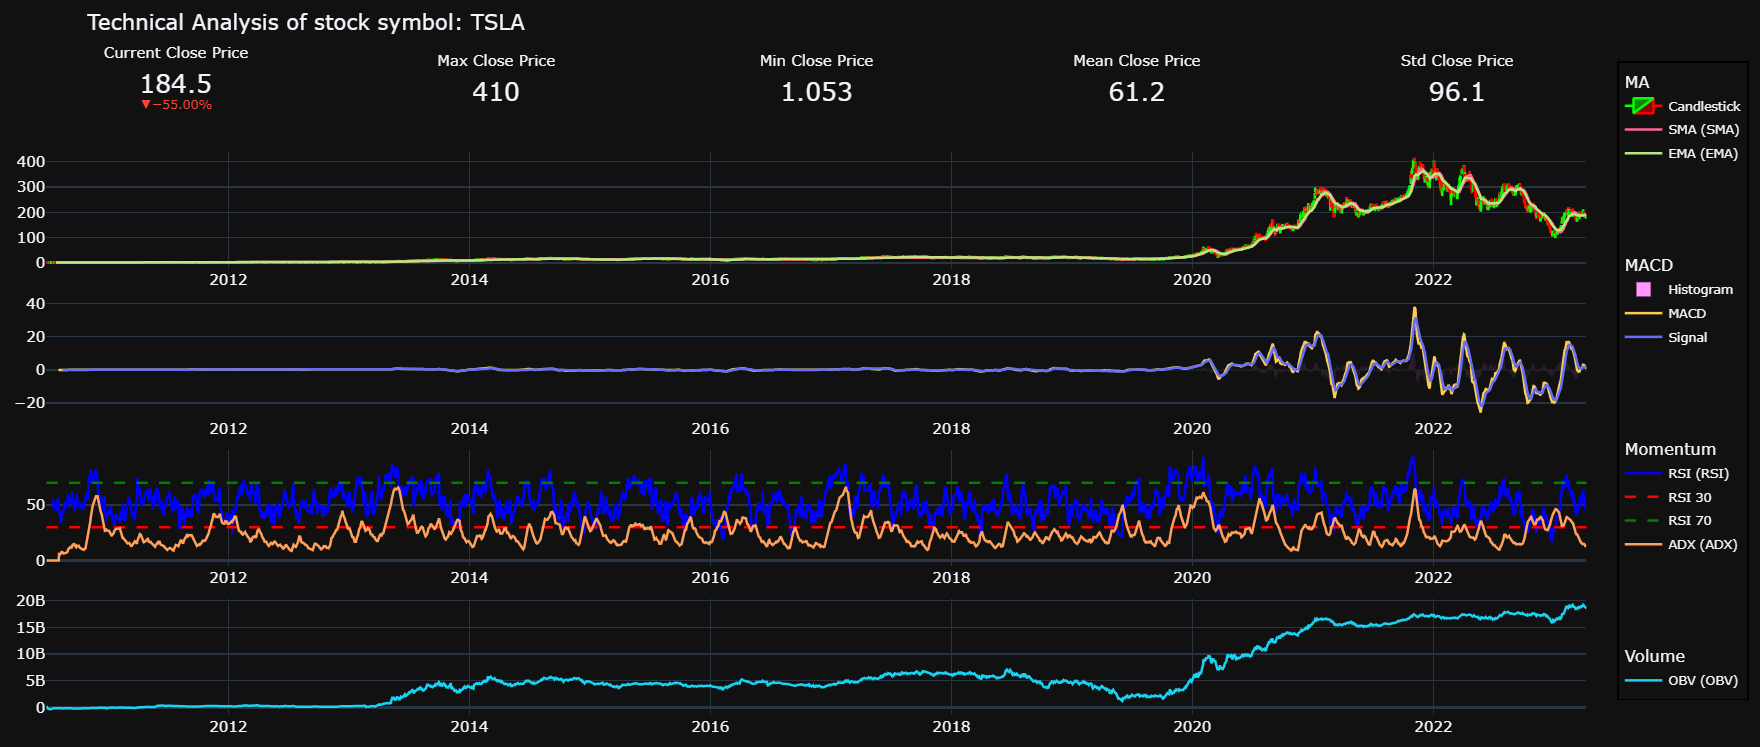